
# CSCI E-25
## Extracting Features From Images
### Steve Elston

Feature extraction from images is a fundamental aspect of computer vision. Image features must be extracted for many computer vision methods. Just a few of these are:    
1. Stitching images together.   
2. Locating and identifying objects in images.    
3. Models of motion from a series of images.     
4. Stereo vision and depth estimation.    

In these exercises we focus on classical methods for extracting features from images. In state-of-the-art practice features are created using deep neural networks. Will address learning features with deep neural networks extensively latter. Rest assured that some background in classical methods will help you understand and appreciate the deep learning methods.     

To get started, execute the code in the cell below to import the packages you will need for the exercises.

In [1]:
import skimage 
from skimage import data
from skimage.filters.rank import equalize, entropy
import skimage.filters as skfilters
import skimage.feature as feature
import skimage.segmentation as segmentation
import skimage.morphology as morphology
import skimage.transform as transform
import skimage.util as util
from skimage.color import rgb2gray
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the Image     

Regardless of the methods used an image must be prepared for feature extraction. Often many steps of correcting and filtering the image are required for proper feature extraction. An important step is the adjustment of the spectrum of the image. We need the spectrum to be as wide as possible. We call the transformation  **pre-whitening**. The broad spectrum is considered white light has all spectral components equally represented. We have already discussed the process of whitening the spectrum of images, contrast improvement. An image with high contrast has a broad spectrum.              

The cat image requires little preprocessing, beyond pre-whitening. Execute the code in the cell below to load and prepare the cat image.

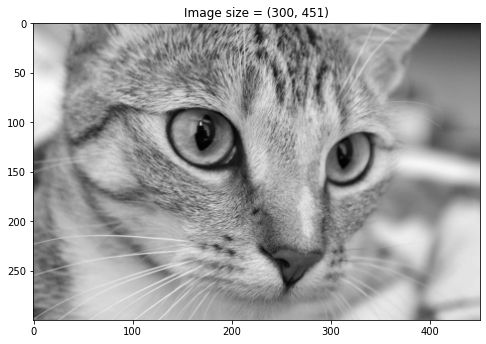

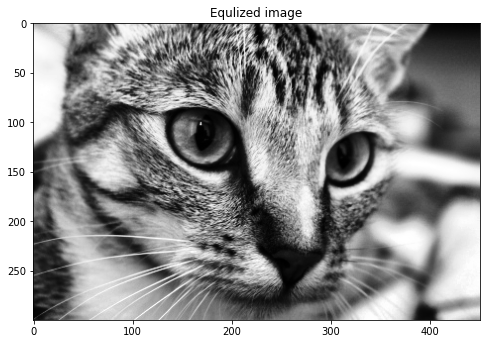

In [12]:
def plot_grayscale(img, title, h=8):
    plt.figure(figsize=(h, h))
    _=plt.imshow(img, cmap=plt.get_cmap('gray'))
    _=plt.title(title)

cat_image = rgb2gray(data.cat())
plot_grayscale(cat_image, 'Image size = ' + str(cat_image.shape))

cat_grayscale_equalized = exposure.equalize_adapthist(cat_image.flatten()).reshape(cat_image.shape)
plot_grayscale(cat_grayscale_equalized, 'Equlized image')

> **Important note!** Unless otherwise stated, the `cat_grayscale_equalized` image should be used for subsequent exercises. 

## Edge Detection  

**Edges** are a fundamental feature of am image. Edges are characterized by rapid changes in the intensity and are therefore associated with **high gradients**. The rapid change in intensity levels also means that the spectrum around an edge will have high-frequency components. 

We can take advantage of the broad spectrum at edge features to create an edge detector algorithm. Recall that a Gaussian filter acts is low-pass, reducing the high frequency components. If we take the difference of the Gaussian filters with different bandwidths we can detect edges.              

> **Exercise 3.1:** To gain a bit of understanding from a simple case you will create a simple one dimensional example of an edge detector. In this case, you will apply a convolutional gradient operator to a square wave function that is first positive and then negative. Aficionados of obscure functions will notice this is a Harr basis function (Harr, 1909). You will find and display the changes in gradient of this function by the following steps:   
> 1. Create the 1-d convolution operator as a Numpy array: $[0.5,-1.0,0.5]$.
> 2. Convolve the `series` with the operator using  the [numpy.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) function. Make sure to set the `mode='same'` argument so the resulting series is the same length as the original.  
> 3. Plot the result with the `plot_conv` function provided. 

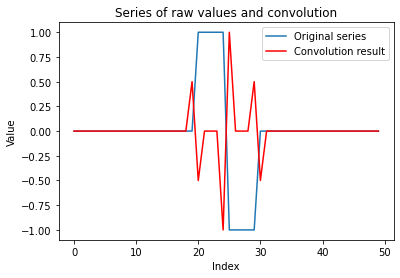

In [13]:
def plot_conv(series, conv, span):
    x = list(range(series.shape[0]))
    plt.plot(x, series, label = 'Original series')
    plt.plot(x, conv, color = 'red', label = 'Convolution result')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and convolution')

series = np.concatenate((np.zeros((20,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((20,))))    
    
##  Your code goes here    
convolution_operator=np.array([0.5,-1.0,0.5])
convolved_series=np.convolve(series,convolution_operator,mode='same')
plot_conv(series,convolved_series,1)

> Examine the plot and answer the following questions:   
> 1. Why are the 3-point convolution operator values correct in terms of sign, and normalization?   
> 2. Does the magnitude of the resulting series correctly represent the gradient of the original series, and why?  
> **End of exercise.**

> **Answers:**
> 1. 
> 2.   

> **Exercise 3-2:** You will now create and test an edge detector using the difference of Gaussian filtered images. Starting with the equalized gray-scale image, perform the following steps:
> 1. Define a first vector of values of $\sigma_1 = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]$ and a second value of $\sigma_2 = 0.5$. 
> 2. For each value of the $\sigma_1$ compute an image which is the difference between the Gaussian filtered images computed with $\sigma_1$ and $\sigma_2$.
> 3. Display each resulting image, with the value of $\sigma_1$ in the title.

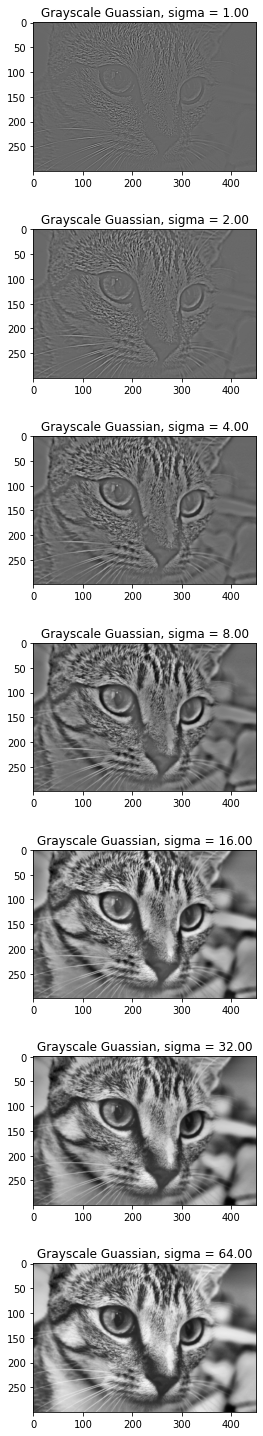

In [39]:
sigma1 = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]
sigma2 = 0.5
##  Your code goes here  

fig, ax = plt.subplots(len(sigma1), 1, figsize=(4,26))
ax = ax.flatten()
## Put your code below

sigma5_cat=skimage.filters.gaussian(cat_grayscale_equalized,sigma=sigma2)

for i in range(len(sigma1)):        
    gaussian_grayscale = sigma5_cat-skimage.filters.gaussian(cat_grayscale_equalized,sigma=sigma1[i])
    _=ax[i].imshow(gaussian_grayscale, cmap=plt.get_cmap('gray'))
    _=ax[i].set_title('Grayscale Guassian, {} = {:.2f}'.format("sigma",sigma1[i]))

> Answer the following questions:
> 1. How does the gradient measurement of the images change as the value of $\sigma_1$ changes and what does this tell you about the scale of features in the image?    
> 2. Given the bandwidths of these Gaussian filters compared to the filter with $\sigma = 0.5$, do the changes of gradient measured make sense and why?     
> 3. Does it appear that the difference of Gaussian filters has detected high gradients with different orientations on the image, and why?  
> **End of exercise.** 

> **Answers:**     
> 1. 
> 2.  
> 3. 

> **Exercise 3-3:** One approach to finding edges is to look for areas of maximum gradient in an image. The difference of Gaussian filters has a strong response to large gradients in image intensity that define edges. In many cases a boolean indicator of an edge is required. To create such an edge indicator from the difference of Gaussian filtered images (equalized gray-scale) with $\sigma_1 = 1.0$ and $\sigma_2 = 0.5$ perform the following steps:    
> 1 Use the [skimage.filters.threshold_otsu](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu) function to compute a threshold value for the gradient.       
> 2. Apply the threshold and create an image of boolean type.   
> 3. Display the boolean image.

Otsu Threshold: 0.02119734837012016


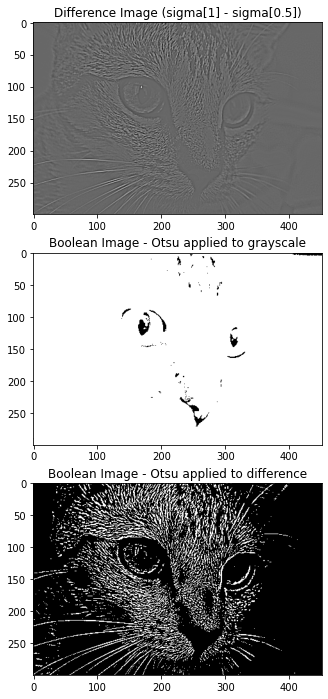

In [40]:
s1=1.0
##  Your code goes here  
sigma1_cat=skimage.filters.gaussian(cat_grayscale_equalized,sigma=s1)
difference_cat=sigma5_cat-sigma1_cat
otsu=skimage.filters.threshold_otsu(difference_cat)
otsu_cat_grayscale = cat_grayscale_equalized >= otsu
otsu_difference = difference_cat >= otsu
print("Otsu Threshold: {}".format(otsu))

fig, ax = plt.subplots(3, 1, figsize=(12,12))
ax = ax.flatten()
_=ax[0].imshow(difference_cat, cmap=plt.get_cmap('gray'))
_=ax[0].set_title('Difference Image (sigma[1] - sigma[0.5])')
_=ax[1].imshow(otsu_cat_grayscale, cmap=plt.get_cmap('gray'))
_=ax[1].set_title('Boolean Image - Otsu applied to grayscale')
_=ax[2].imshow(otsu_difference, cmap=plt.get_cmap('gray'))
_=ax[2].set_title('Boolean Image - Otsu applied to difference')

> Examine the results and answer the following questions:     
> 1. Has the binarization process captured the edges at all possible orientations, and why?     
> 2. Based on your observation, do you think the edge features are sufficient to identify the animal in the image as a cat within reasonable certainty?     
> **End of exercise.**

> **Answers:**
> 1.    
> 2. 

Now that you have a bit of experience with edge detection, we will explore a few of the many commonly used edge detection algorithms. As you proceed notice how different algorithms produce different results. 

> **Exercise 3-4:** The Sobel filter is another form of edge detector. You will now apply the [skimage.filters.sobel](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel) function to the equalized gray-scale cat image. In this case you will simply compute the norm and not the directions. Then, display the result.

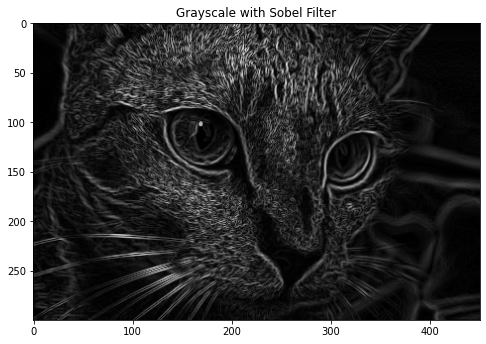

In [25]:
##  Your code goes here  
sobel_cat=skimage.filters.sobel(cat_grayscale_equalized)
plot_grayscale(sobel_cat, "Grayscale with Sobel Filter")

> 3. Next compute the binary image use the [skimage.filters.threshold_otsu](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu) function to find a threshold, apply the threshold found and display the result. **Hint:** Notice that you can biniarize the image by taking pixels greater than or equal to or less than or equal to the threshold. 

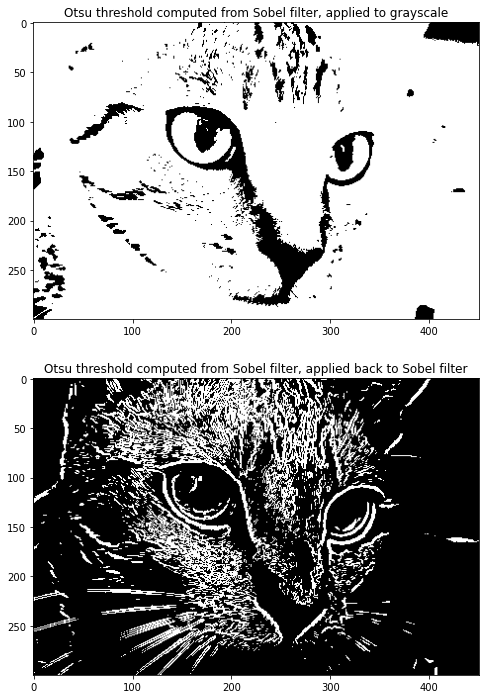

In [26]:
##  Your code goes here  
otsu_sobel=skimage.filters.threshold_otsu(sobel_cat)
otsu_sobel_grayscale = cat_grayscale_equalized >= otsu_sobel
otsu_sobel_binary = sobel_cat >= otsu_sobel

fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax = ax.flatten()
_=ax[0].imshow(otsu_sobel_grayscale, cmap=plt.get_cmap('gray'))
_=ax[0].set_title('Otsu threshold computed from Sobel filter, applied to grayscale')
_=ax[1].imshow(otsu_sobel_binary, cmap=plt.get_cmap('gray'))
_=ax[1].set_title('Otsu threshold computed from Sobel filter, applied back to Sobel filter')

> Compare the edges found with the Sobel filter with those found by the difference of Gaussian filters. Answer the following questions:   
> 1. Which aspects of the edges found by the two methods are substantially similar? 
> 2. How do the edge features detected by the two methods differ, in particular in terms of texture, continuity, compactness, etc? 

> **Answers:**   
> 1.  
> 2. 

## Corner Detection    

Along with edges, corners are another fundamental feature of images. Detection of corners is fundamentally more difficult than edges:   
1. Corners are multi-dimensional so a require more than just a first order gradient for detection.     
2. Corers are two-dimensional and have orientation.     
3. The angel forming the corner is a fundamental characteristic and changing the angel changes the characteristic of the corner.     
As a result of these fundamental characteristics, corner detectors must be based on metrics of multi-dimensional changes in intensity. As an example, the **Sobel** edge detector is a $2 \times 2$ array of all possible second partial derivatives. This formulation allows us to determine both the presence and the orientation (direction) of corners.            

> **Exercise 3-5:** The Harris corner detector is one of the many widely use algorithms to detect corner features in images. The detector finds a set of x-y coordinates for each corner that meets a threshold. Apply the [skimage.feature.corner_harris](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.corner_harris) function to the equalized gray scale cat image by the following steps:
> 1. Apply the Harris corner detector to the equalized gray-scale image.
> 2. Use a for loop to iterate over values of the `min_distance` argument, $[1,3,5,9,12,20]$ and then perform tee steps below.       
> 3. Use the [skimage.features.corner_peaks](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.corner_peaks) to filter the corner features using the `min_distance` value. 
> 4. Print the minimum distance and the number of corner features the filtering.
> 5. Side by side, plot the gray-scale and the gradient image computed with the difference of Gaussian filtered images with $\sigma_1 = 2.0$ and $\sigma_2 = 0.5$. Superimpose on these images corners detected using a '+' marker for the corners.

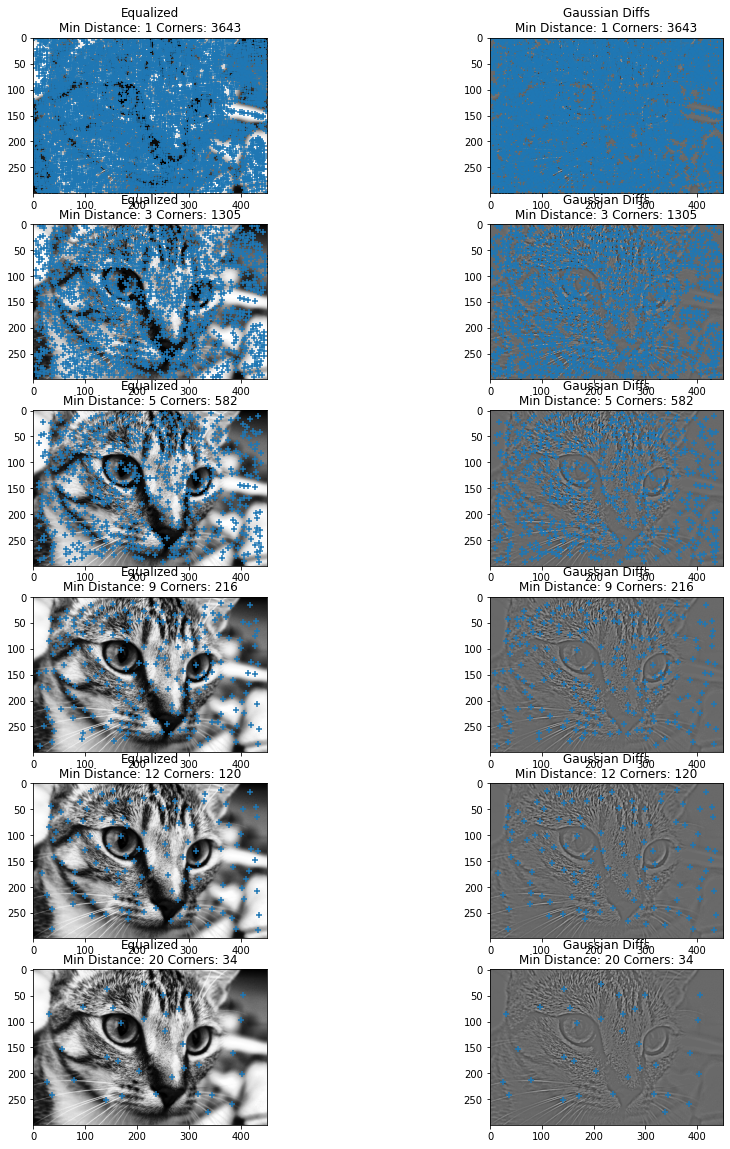

In [47]:
##  Your code goes here  
from skimage.feature import corner_harris, corner_peaks

min_distance=[1,3,5,9,12,20]
fig, ax = plt.subplots(len(min_distance), 2, figsize=(15,20))
ax = ax.flatten()

corners = corner_harris(cat_grayscale_equalized)

sigma2_cat=skimage.filters.gaussian(cat_grayscale_equalized,sigma=2)
gaussian_diff_cat=sigma5_cat-sigma2_cat

for i, distance in enumerate(min_distance):
    corner_features = corner_peaks(corners, min_distance=distance)
    #print("Minimum distance: {}, corner features: {}".format(distance,corner_features.shape[0]))

    _=ax[2*i].imshow(cat_grayscale_equalized, cmap=plt.get_cmap('gray'))
    _=ax[2*i].set_title('Equalized\nMin Distance: {} Corners: {}'.format(distance,corner_features.shape[0]))
    _=ax[2*i].scatter(corner_features[:,1], corner_features[:,0],marker='+')

    _=ax[2*i+1].imshow(gaussian_diff_cat, cmap=plt.get_cmap('gray'))
    _=ax[2*i+1].set_title('Gaussian Diffs\nMin Distance: {} Corners: {}'.format(distance,corner_features.shape[0]))
    _=ax[2*i+1].scatter(corner_features[:,1], corner_features[:,0],marker='+')


> Examine the results and images and answer these questions:    
> 1. How can you describe the change in the number of corner features as the minimum distance is increased, and why?  
> 2. Do the features that remain as the minimum distance increases appear more robust (or obviously corners to the eye) given the gradient computed with the difference of Gaussians?   
> 3. Consider a trade-off between using a large set of features which may better represent a specific image vs. a sparser but more robust set of features. How might you decide how to optimally filter the features?   

> **Answers:**    
> 1.    
> 2. 
> 3.   

### Eigenvalues and Corner Detection     

Now that you have worked with a corner detection algorithm, you will create your own using eigenvalues. This algorithm is a simplified version of the well-known SIFT algorithm. The algorithm uses the ratio of the eigenvalues to find corners with changes in gradient. The steps of this algorithm are:    
1. The Hessian for each pixel in the image is computed using the operator span specified, $\sigma$.   
2. The eigenvalues of the Hessians are computed.  
3. The ratio of the largest to the second eigenvalue is computed.   
4. The eigenvalue ratio is thresholded to reduce the number of features. 

> **Exercise 3-6:** You will now implement the corner detection and examine the results by the following steps:   
> 1. Compute the Hessian of the equalized gray-scale cat image using [skimage.feature.hessian_matrix](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hessian_matrix), iterated over values of $\sigma = [0.2,0.5,1.0,2.0,4.0]$.    
> 2. For each Hessian compute the eigenvalues using [skimage.feature.hessian_matrix_eigvals](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hessian_matrix_eigvals).    
> 3. Compute the ratio of the first and second eigenvalues. These values can be found in the first (largest) and second elements of the list returned by the `hessina_matrix_eigvals` function.   
> 4. Apply a threshold of $0.01$ to the largest largest eigenvalues. If the larges eigenvalue is less than the threshold set the eigenvalue ration to $10^{-6}$.   
> 5. Display images for the components of the Hessian, $[HRR, HRC, HCC]$, along with the image of the thresholded eigenvalue ratio. Make sure to label all images with the operator span and the Hessian components.    

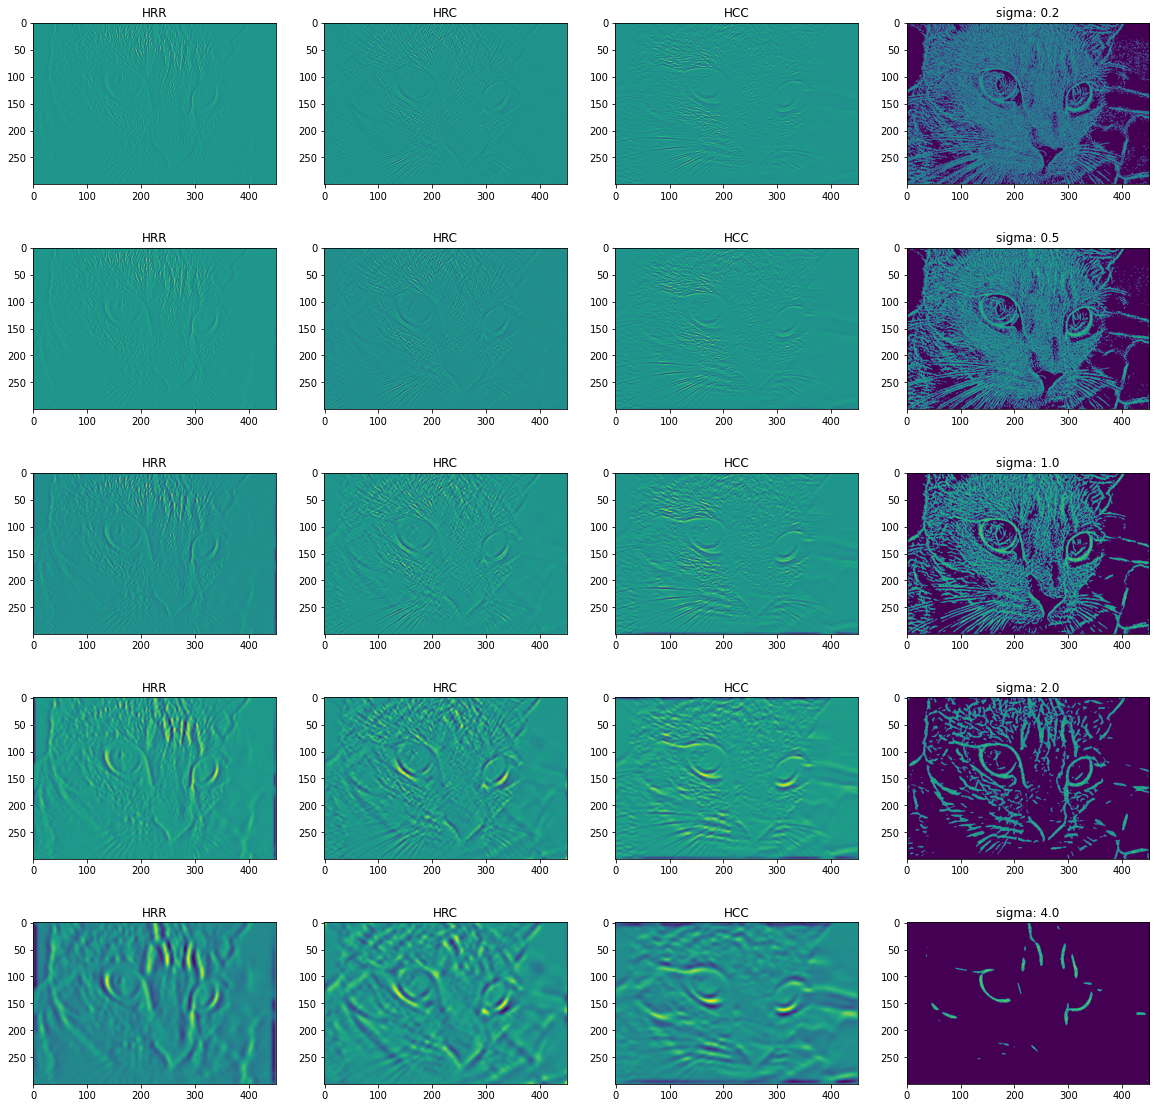

In [82]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

sigma_list = [0.2,0.5,1.0,2.0,4.0]
threshold = 0.01

##  Your code goes here  
fig, ax = plt.subplots(len(sigma_list), 4, figsize=(20,20))
ax = ax.flatten()

for i,sigma in enumerate(sigma_list):        
    Hrr, Hrc, Hcc = skimage.feature.hessian_matrix(cat_grayscale_equalized, sigma=sigma, order = "rc")
    hessian=hessian_matrix(cat_grayscale_equalized, sigma=sigma)
    eigenvals=hessian_matrix_eigvals(hessian)
    largest = np.abs(eigenvals[0])

    #threshold = threshold * np.max(eigenvals[0])
    ratio = np.where(largest < threshold, 10e-6, np.divide(largest, np.abs(eigenvals[1])))
    
    _=ax[4*i].imshow(Hrr)
    _=ax[4*i].set_title('HRR')
    
    _=ax[4*i+1].imshow(Hrc)
    _=ax[4*i+1].set_title('HRC')    
    
    _=ax[4*i+2].imshow(Hcc)
    _=ax[4*i+2].set_title('HCC')
    
    _=ax[4*i+3].imshow(np.log(ratio))
    _=ax[4*i+3].set_title('sigma: {}'.format(sigma))

> Answer the following questions:   
> 1. How can you describe the how the components of the Hessian change as the span of the Hessian operator, $\sigma$, changes and why?
> 2. What differences can you see between the components of the Hessian and why?   
> 3. What differences do you see in the feature image as the span of the Hessian operator, $\sigma$, changes and why?
> **End of exercise**.

> **Answers:**    
> 1.    
> 2.     
> 3.   

## Interest Point Descriptors   

In many computer vision applications, including image stitching, stereo vision, and flow (motion tracking), require the unique identification of interest points. 

### The HOG Algorithm

The orientation of corners can be used as part of a representation or feature map of an image. As with corner detection, a great many algorithms for determining corner orientation have been developed. Here, we will only work with the **HOG** or **histograms of oriented gradients** algorithm. The algorithm finds the directional bin with maximum value for a histogram of the gradients over patches of the image.  

The [skimage.feature.hog](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog) function returns a list. The first element of the list is a vector of the magnitude of the gradients. The second element of the list is a $2 \times 2$ array of orientation vectors. When a visualization is performed, the long axis of the markers shows the orientation and the width of the marker indicates the magnitude of the gradient.      

> **Exercise 3-7:** You will now apply the HOG algorithm to the equalized gray-scale cat image. You will compare the results of using a different number of pixels per cell to estimate the histogram of 9 orientations by the following steps:
> 1. Iterate over tuples for the `pixels_per_cell` argument with dimensions, $[(4,4), (8,8), (16,16), (32,32)]$ for the convolutional operator, and for each tuple do the rest of these steps.
> 2. Compute the gradient orientations using the `pixels_per_cell` argument and with `visualize=True`.
> 3. Print the pixels per cell tuple, with the dimensions of the operator and the number of HOGs returned by the function in the title of each image. The number of HOGs is in the first element of the list returned by the `hog` function.    
> 4. Display the gray-scale image of the corner orientations. 

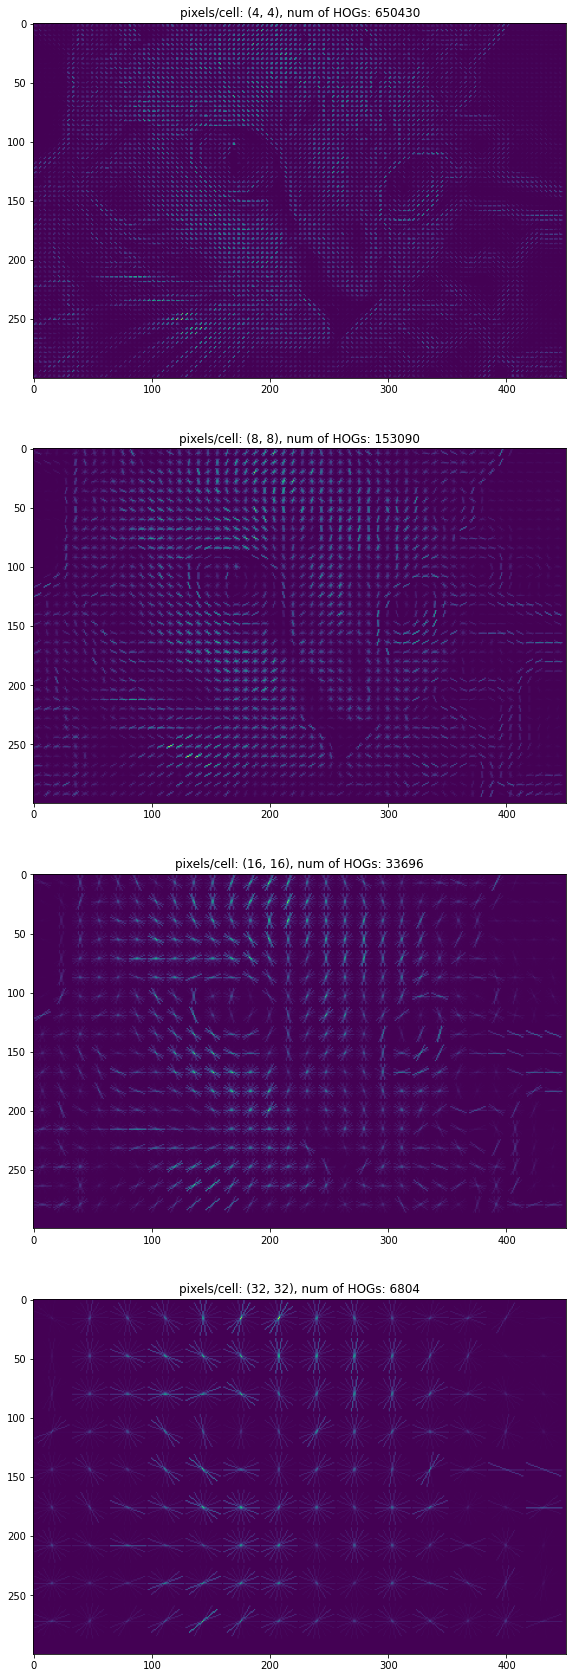

In [101]:
##  Your code goes here  
from skimage.feature import hog 

pixels_per_cells=[(4,4),(8,8),(16,16),(32,32)]  

fig, ax = plt.subplots(len(pixels_per_cells), 1, figsize=(30,30))
ax = ax.flatten()

for i,pixels_per_cell in enumerate(pixels_per_cells):        
    n_hogs,hog_image=hog(cat_grayscale_equalized,pixels_per_cell=pixels_per_cell,visualize=True)
    _=ax[i].imshow(hog_image)
    _=ax[i].set_title('pixels/cell: {}, num of HOGs: {}'.format(pixels_per_cell, len(n_hogs)))

> Examine the results and answer the following questions:       
> 1. How has the density of the corner direction features changes as the pixels per cell dimensionality increases and why?      
> 2. How does the magnitude of the gradient change as the pixels per cell and scale increases and does this make sense given the algorithm and why?     
> 3. How does the smoothness and consistency of the gradient directions as the pixels per cell dimensionality or scale increases and does this make sense given the algorithm and why?   
> 4. As the size of the operator increases, you can see that the representation of the cat image changes, becoming more abstracted. If you goal is to robustly represent the object what do you think the trade-off will be and why?    
> **End of exercise.**

> **Answers:**
> 1.     
> 2.  
> 3.   
> 4. 

### The BRIEF Algorithm   

As with edge and corner detectors, a great many **interest point detection** algorithms have been developed. Here we will only work with one, the BRIEF algorithm. The BRIEF algorithm creates a hash of the gradient directions over patches of the image. These hashes can be matched between images to find common interest points.                   

> **Exercise 3-8:** You will now apply the [sskimage.feature.BRIEF](https://scikit-image.org/docs/0.18.x/api/skimage.feature.html?highlight=brief#skimage.feature.BRIEF) function to the equalized gray-scale cat image by the following steps:     
> 1. Apply the Harris corner detection algorithm to the equalized gray-scale cat image. 
> 2. Find the Harris corner peaks with `min_distance=5`, and print the number of peaks found. 
> 3. Initialize the BRIEF feature extractor with `patch_size=5`.
> 4. Extract the BRIEF descriptor hashes from the cat gray-scale image and the corner peaks found. The function returns an object with many attributes. The descriptor hash is the `.descriptor` attribute. 
> 5. Print the first 4 hashes, being careful to label them.      
> 6. Compute the similarity [**Hamming distance**](https://en.wikipedia.org/wiki/Hamming_distance) between the first hash and all subsequent hashes.
> 7. Display a histogram of the Hamming distances using 30 bins and the range limited to the possible similarity values. Make sure you label the axes and provide a meaningful title for your chart. 

In [102]:
##  Your code goes here  

from skimage.feature import BRIEF 

corners = corner_harris(cat_grayscale_equalized)
corner_features = corner_peaks(corners, min_distance=5)

extractor = BRIEF(patch_size=5)
extractor.extract(cat_grayscale_equalized, corner_features)
descriptors = extractor.descriptors

In [106]:
descriptors.shape

(582, 256)

> Examine the images noticing how the pattern of interest point rings changes as the radius of the outer ring increases and answer the following questions.
> 1. How does the distribution of the interest points change as the radius of the outer ring increases.   
> 2. Paying careful attention to the markers at the center of the rings, notice how the centers converge at large out ring radii. What conclusion can you draw about the importance of these interest points?         
> **End of exercise.**

> **Answers:**    
> 1. 
> 2. 

## Texture       

Texture is a ubiquitous feature of nearly all images. However, stating exactly what texture is, and how to measure it, is not simple or strait forward. In general, we can say that texture is a function of local variation of the image. Typical measures used to quantify texture are:     
- Covariance over local patches of the image where regions with higher covariance have rougher textures.       
- Entropy computed over local patches of the image where regions with higher entropy have rougher textures.   

Here we will focus on local entropy to measure texture using the [skimage.filters.rank.entropy](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.entropy) function. 
ids

> **Exercise 3-9:** You will now use local entropy  as a measure of texture on the equalized gray-scale cat image by doing the following.    
> 1. Iterate over the disk patch diameters, $[3,6,12,24,48,96]$, and for each value do each of the following steps. 
> 2. Compute the local entropy of the color (3-channel) cat image using the [skimage.morphology.disk](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.disk) for the patch argument, and using the diameter value. Make sure you convert the image to unsigned 8-bit integer with [skimage.util.img_as_ubyte](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.img_as_ubyte).    
> 3. Side by side, display the image and a histogram of the entropy values with 50 bins. Include a title with the disk diameter and axes labels for the histogram.    

In [ ]:
##  Your code goes here  







> Examine histogram of the hash similarity values. Keeping in mind the maximum and minimum possible values, what statement can you make about how strong the similarity is between these interest points. Try to explain your reasoning.          
> **End of exercise.**

> **Answer:**   

#### Copyright 2021, Stephen F Elston. All rights reserved.